In [45]:
import warnings
from typing import Dict, List, NamedTuple, Optional, Tuple, Union

import plotly.graph_objects as go
import torch
import glob
import os
import numpy as np
from plotly.subplots import make_subplots
from pytorch3d.renderer.cameras import CamerasBase
from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.utils import cameras_from_opencv_projection

import matplotlib.cm as cm

In [6]:
Struct = Union[CamerasBase]

In [7]:
class AxisArgs(NamedTuple):  # pragma: no cover
    showgrid: bool = False
    zeroline: bool = False
    showline: bool = False
    ticks: str = ""
    showticklabels: bool = False
    backgroundcolor: str = "#fff"
    showaxeslabels: bool = False

In [41]:
def pose2pytorch3d(pose):
    """
    Convert a pose from OpenGL format to pytorch3d format
    Input:
        pose: 4x4 matrix
    Output:
        cameras: FoVPerspectiveCameras object
    """

    # Convert to pytorch3d format
    R = pose[:3, :3]
    T = pose[:3, 3]
    T = T.reshape(1, 3)
    R = R.reshape(1, 3, 3)
    
    cameras = FoVPerspectiveCameras(R=R, T=T, fov=90)

    return cameras

In [14]:
def convert_poses_opengl(poses: List[np.array], coordinate_frame: str) -> List[np.array]:

    if coordinate_frame == 'opencv':
        transform_to_opengl = np.array([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1],
        ])
    elif coordinate_frame == 'blender':
        transform_to_opengl = np.array([
            [0, 0, 1, 0],
            [-1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, 0, 1],
        ])
    elif coordinate_frame == 'pytorch3d':
        transform_to_opengl = np.array([
            [1, 0, 0, 0],
            [0, 0, -1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ])
    else:
        raise ValueError(f'Unknown coordinate frame {coordinate_frame}')
    
    poses_opengl = []
    for pose in poses:
        pose_opengl = transform_to_opengl @ pose
        poses_opengl.append(pose_opengl)
    
    return poses_opengl

In [131]:
def convert_poses_opencv(poses: List[np.array], coordinate_frame: str) -> List[np.array]:

    if coordinate_frame == 'opengl':
        transform_to_opencv = np.array([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1],
        ])
    elif coordinate_frame == 'blender':
        transform_to_opencv = np.array([
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [1, 0, 0, 0],
            [0, 0, 0, 1],
        ])
    elif coordinate_frame == 'pytorch3d':
        transform_to_opencv = np.array([
            [1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, -1, 0, 0],
            [0, 0, 0, 1],
        ])
    else:
        raise ValueError(f'Unknown coordinate frame {coordinate_frame}')
    
    poses_opencv = []
    for pose in poses:
        pose_opencv = transform_to_opencv @ pose
        poses_opencv.append(pose_opencv)
    
    return poses_opencv

In [15]:
def get_camera_wireframe(scale: float = 0.3):  # pragma: no cover
    """
    Returns a wireframe of a 3D line-plot of a camera symbol.
    """
    a = 0.5 * torch.tensor([-2, 1.5, 4])
    up1 = 0.5 * torch.tensor([0, 1.5, 4])
    up2 = 0.5 * torch.tensor([0, 2, 4])
    b = 0.5 * torch.tensor([2, 1.5, 4])
    c = 0.5 * torch.tensor([-2, -1.5, 4])
    d = 0.5 * torch.tensor([2, -1.5, 4])
    C = torch.zeros(3)
    F = torch.tensor([0, 0, 3])
    camera_points = [a, up1, up2, up1, b, d, c, a, C, b, d, C, c, C, F]
    lines = torch.stack([x.float() for x in camera_points]) * scale
    return lines

In [16]:

def _gen_fig_with_subplots(
    batch_size: int, ncols: int, subplot_titles: List[str]
):  # pragma: no cover
    """
    Takes in the number of objects to be plotted and generate a plotly figure
    with the appropriate number and orientation of titled subplots.
    Args:
        batch_size: the number of elements in the batch of objects to be visualized.
        ncols: number of subplots in the same row.
        subplot_titles: titles for the subplot(s). list of strings of length batch_size.

    Returns:
        Plotly figure with ncols subplots per row, and batch_size subplots.
    """
    fig_rows = batch_size // ncols
    if batch_size % ncols != 0:
        fig_rows += 1  # allow for non-uniform rows
    fig_cols = ncols
    fig_type = [{"type": "scene"}]
    specs = [fig_type * fig_cols] * fig_rows
    # subplot_titles must have one title per subplot
    fig = make_subplots(
        rows=fig_rows,
        cols=fig_cols,
        specs=specs,
        subplot_titles=subplot_titles,
        column_widths=[1.0] * fig_cols,
    )
    return fig


def _update_axes_bounds(
    verts_center: torch.Tensor,
    max_expand: float,
    current_layout: go.Scene,  # pyre-ignore[11]
) -> None:  # pragma: no cover
    """
    Takes in the vertices' center point and max spread, and the current plotly figure
    layout and updates the layout to have bounds that include all traces for that subplot.
    Args:
        verts_center: tensor of size (3) corresponding to a trace's vertices' center point.
        max_expand: the maximum spread in any dimension of the trace's vertices.
        current_layout: the plotly figure layout scene corresponding to the referenced trace.
    """
    verts_center = verts_center.detach().cpu()
    verts_min = verts_center - max_expand
    verts_max = verts_center + max_expand
    bounds = torch.t(torch.stack((verts_min, verts_max)))

    # Ensure that within a subplot, the bounds capture all traces
    old_xrange, old_yrange, old_zrange = (
        current_layout["xaxis"]["range"],
        current_layout["yaxis"]["range"],
        current_layout["zaxis"]["range"],
    )
    x_range, y_range, z_range = bounds
    if old_xrange is not None:
        x_range[0] = min(x_range[0], old_xrange[0])
        x_range[1] = max(x_range[1], old_xrange[1])
    if old_yrange is not None:
        y_range[0] = min(y_range[0], old_yrange[0])
        y_range[1] = max(y_range[1], old_yrange[1])
    if old_zrange is not None:
        z_range[0] = min(z_range[0], old_zrange[0])
        z_range[1] = max(z_range[1], old_zrange[1])

    xaxis = {"range": x_range}
    yaxis = {"range": y_range}
    zaxis = {"range": z_range}
    current_layout.update({"xaxis": xaxis, "yaxis": yaxis, "zaxis": zaxis})


def _scale_camera_to_bounds(
    coordinate: float, axis_bounds: Tuple[float, float], is_position: bool
) -> float:  # pragma: no cover
    """
    We set our plotly plot's axes' bounding box to [-1,1]x[-1,1]x[-1,1]. As such,
    the plotly camera location has to be scaled accordingly to have its world coordinates
    correspond to its relative plotted coordinates for viewing the plotly plot.
    This function does the scaling and offset to transform the coordinates.

    Args:
        coordinate: the float value to be transformed
        axis_bounds: the bounds of the plotly plot for the axis which
            the coordinate argument refers to
        is_position: If true, the float value is the coordinate of a position, and so must
            be moved in to [-1,1]. Otherwise it is a component of a direction, and so needs only
            to be scaled.
    """
    scale = (axis_bounds[1] - axis_bounds[0]) / 2
    if not is_position:
        return coordinate / scale
    offset = (axis_bounds[1] / scale) - 1
    return coordinate / scale - offset

In [33]:


def _add_camera_trace(
    fig: go.Figure,
    cameras: CamerasBase,
    trace_name: str,
    subplot_idx: int,
    ncols: int,
    camera_scale: float,
    color: List[float],
    opacity: float = 1.0,
) -> None:  # pragma: no cover
    """
    Adds a trace rendering a Cameras object to the passed in figure, with
    a given name and in a specific subplot.

    Args:
        fig: plotly figure to add the trace within.
        cameras: the Cameras object to render. It can be batched.
        trace_name: name to label the trace with.
        subplot_idx: identifies the subplot, with 0 being the top left.
        ncols: the number of subplots per row.
        camera_scale: the size of the wireframe used to render the Cameras object.
    """
    cam_wires = get_camera_wireframe(camera_scale).to(cameras.device)
    cam_trans = cameras.get_world_to_view_transform().inverse()
    cam_wires_trans = cam_trans.transform_points(cam_wires).detach().cpu()
    # if batch size is 1, unsqueeze to add dimension
    if len(cam_wires_trans.shape) < 3:
        cam_wires_trans = cam_wires_trans.unsqueeze(0)

    nan_tensor = torch.Tensor([[float("NaN")] * 3])
    all_cam_wires = cam_wires_trans[0]
    for wire in cam_wires_trans[1:]:
        # We combine camera points into a single tensor to plot them in a
        # single trace. The NaNs are inserted between sets of camera
        # points so that the lines drawn by Plotly are not drawn between
        # points that belong to different cameras.
        all_cam_wires = torch.cat((all_cam_wires, nan_tensor, wire))
    x, y, z = all_cam_wires.detach().cpu().numpy().T.astype(float)

    # Scale colours to 255 int
    color = [int(c * 255) for c in color]
    color[-1] = opacity

    row, col = subplot_idx // ncols + 1, subplot_idx % ncols + 1
    fig.add_trace(
        go.Scatter3d(x=x, y=y, z=z, marker={
            "size": 1,
            "color": f"rgba{str(tuple(color))}",
        }, name=trace_name),
        row=row,
        col=col,
    )

    # Access the current subplot's scene configuration
    plot_scene = "scene" + str(subplot_idx + 1)
    current_layout = fig["layout"][plot_scene]

    # flatten for bounds calculations
    flattened_wires = cam_wires_trans.flatten(0, 1)
    verts_center = flattened_wires.mean(0)
    max_expand = (flattened_wires.max(0)[0] - flattened_wires.min(0)[0]).max()
    _update_axes_bounds(verts_center, max_expand, current_layout)


In [77]:
def plot_cameras(poses, coordinate_frame='opengl', camera_scale=0.3, scheme='rainbow', c2w=True, **kwargs):

    # Convert poses back to opengl if not in opengl format
    if coordinate_frame != 'opencv':
        poses = convert_poses_opencv(poses, coordinate_frame)

    if c2w:
        poses = [np.linalg.inv(pose) for pose in poses] # Pytorch3D uses world-to-camera convention
    
    K = torch.eye(3)[None, ...]
    K[..., 0, 0] = K[..., 1, 1] = 512
    K[..., 0, 2] = K[..., 1, 2] = 256

    poses = [cameras_from_opencv_projection(
        torch.from_numpy(pose[:3, :3][None, ...]),
        torch.from_numpy(pose[:3, 3][None, ...]),
        K,
        torch.ones(1, 2) * 512,
    ) for pose in poses]

    fig = _gen_fig_with_subplots(1, 1, ["All Poses"])
    axis_args_dict = kwargs.get("axis_args", AxisArgs())._asdict()

    # Set axis arguments to defaults defined at the top of this file
    x_settings = {**axis_args_dict}
    y_settings = {**axis_args_dict}
    z_settings = {**axis_args_dict}

    # Update the axes with any axis settings passed in as kwargs.
    x_settings.update(**kwargs.get("xaxis", {}))
    y_settings.update(**kwargs.get("yaxis", {}))
    z_settings.update(**kwargs.get("zaxis", {}))

    camera = {
        "up": {
            "x": 0.0,
            "y": 1.0,
            "z": 0.0,
        }  # set the up vector to match PyTorch3D world coordinates conventions
    }
    
    colormap = cm.get_cmap(scheme)
    colors = colormap(np.linspace(0, 1, len(poses)))

    for i, pose in enumerate(poses):
        _add_camera_trace(fig, pose, i, 0, 1, camera_scale, colors[i])

    return fig

# Test on OpenCV Poses

In [184]:
poses_dir = "pose"
pose_files = sorted(glob.glob(os.path.join(poses_dir, "2_*.txt")))
poses_cv  = [np.loadtxt(pose_file) for pose_file in pose_files]

poses = []
for pose in poses_cv:

    # We did inverse pose since the given pose is camera->world and pytorch3d expects world->camera

    pose = np.linalg.inv(pose) # make it world->camera
    # pose[1:3, :] *=-1 # converts to opengl world-> camera from opencv world->camera

    # pose[:3, :3] = np.linalg.inv(pose[:3, :3]) # From here - https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/renderer/camera_conversions.py
    # pose[2, :] *= -1
    # pose[0, :] *= -1
    # pose[:2, 3] *= -1

    poses.append(pose)
# poses.append(np.eye(4))

plot_cameras(poses, coordinate_frame='opencv', camera_scale=0.5)

In [185]:
from extrinsic import CameraPoseVisualizer
import matplotlib.pyplot as plt

initialize camera pose visualizer


/Users/jaidev/Desktop/GIT-Projects/Camera-Pose-Verifier/extrinsic.py:12: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



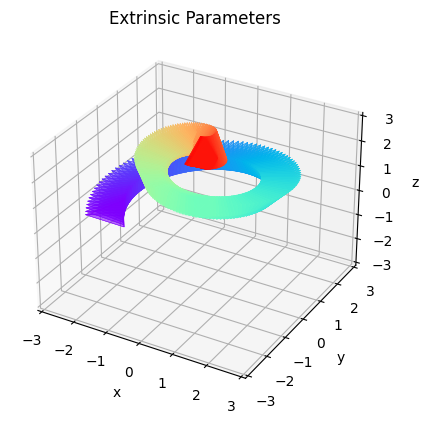

In [187]:
visualizer = CameraPoseVisualizer([-3, 3], [-3, 3], [-3, 3])

for i, pose in enumerate(poses):
    visualizer.extrinsic2pyramid(np.linalg.inv(pose), plt.cm.rainbow(i/len(poses)), 1)
# visualizer.colorbar(len(data_poses))
visualizer.show()

# Test on NeRFStudio Trajectory

In [195]:
poses_inp = np.load("indoor.npy")
pose_cv = convert_poses_opencv(poses_inp, 'opengl')

poses = []
for pose in pose_cv:

    # pose[:, :3] *= -1
    pose = np.linalg.inv(pose) # make it world->camera

    print(np.round(pose, 2))

    # pose[1:3, :] *= -1
    poses.append(pose)

plot_cameras(poses, coordinate_frame='opencv', camera_scale=0.5)

[[ 1.  0.  0. -0.]
 [ 0.  1. -0. -0.]
 [ 0.  0.  1. -0.]
 [ 0.  0.  0.  1.]]
[[ 0.95  0.   -0.31  1.78]
 [-0.06  0.98 -0.2  -0.25]
 [ 0.3   0.21  0.93 -0.06]
 [ 0.    0.    0.    1.  ]]
[[ 0.78 -0.    0.63 -3.22]
 [ 0.05  1.   -0.07 -0.72]
 [-0.63  0.08  0.77  1.16]
 [ 0.    0.    0.    1.  ]]
[[ 0.56  0.    0.83 -3.9 ]
 [ 0.32  0.92 -0.21 -0.16]
 [-0.77  0.38  0.52  1.41]
 [ 0.    0.    0.    1.  ]]
[[ 1.    0.    0.07 -0.93]
 [ 0.06  0.54 -0.84  2.47]
 [-0.04  0.84  0.54 -0.5 ]
 [ 0.    0.    0.    1.  ]]


initialize camera pose visualizer


/Users/jaidev/Desktop/GIT-Projects/Camera-Pose-Verifier/extrinsic.py:12: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



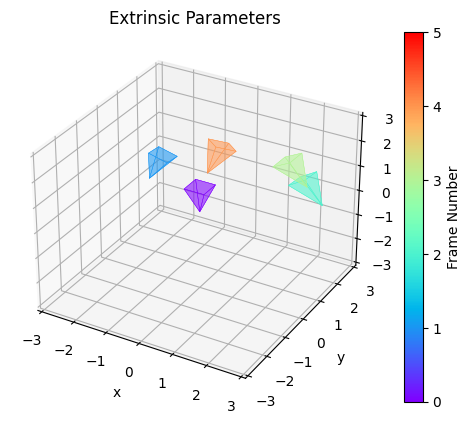

In [203]:
visualizer = CameraPoseVisualizer([-3, 3], [-3, 3], [-3, 3])

for i, pose in enumerate(poses):
    visualizer.extrinsic2pyramid(np.linalg.inv(pose), plt.cm.rainbow(i/len(poses)), 1)
visualizer.colorbar(len(poses))
visualizer.show()